<h1 style='text-align: center;'>Customer Churn Prediction for Telecom</h1>
<h1 style='text-align: center;'>**********************************************************************************<h1>

<h2 style='text-align: center;'>Importing Libraries</h2>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    classification_report, confusion_matrix, roc_curve
)
import shap

In [13]:
import  warnings 
warnings.filterwarnings("ignore")

<h2 style='text-align: center;'>Load Data-Set</h2>

In [19]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [21]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [23]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [29]:
data.notnull().sum().sum()/(data.shape[0]*data.shape[1])*100

100.0

<h2 style='text-align: center;'>Data Cleaning</h2>

In [36]:
data = data.drop(columns=['customerID'])
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data = data.dropna()

<h2 style='text-align: center;'>Encoding categorical features</h2>

In [41]:
for col in data.select_dtypes(include=['object']).columns:
    data[col] = LabelEncoder().fit_transform(data[col])

<h1 style='text-align: center;'>Spliting data</h1>

In [47]:
X = data.drop(columns=['Churn'])
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h2 style='text-align: center;'>Exploratory data analysis (EDA)</h2>

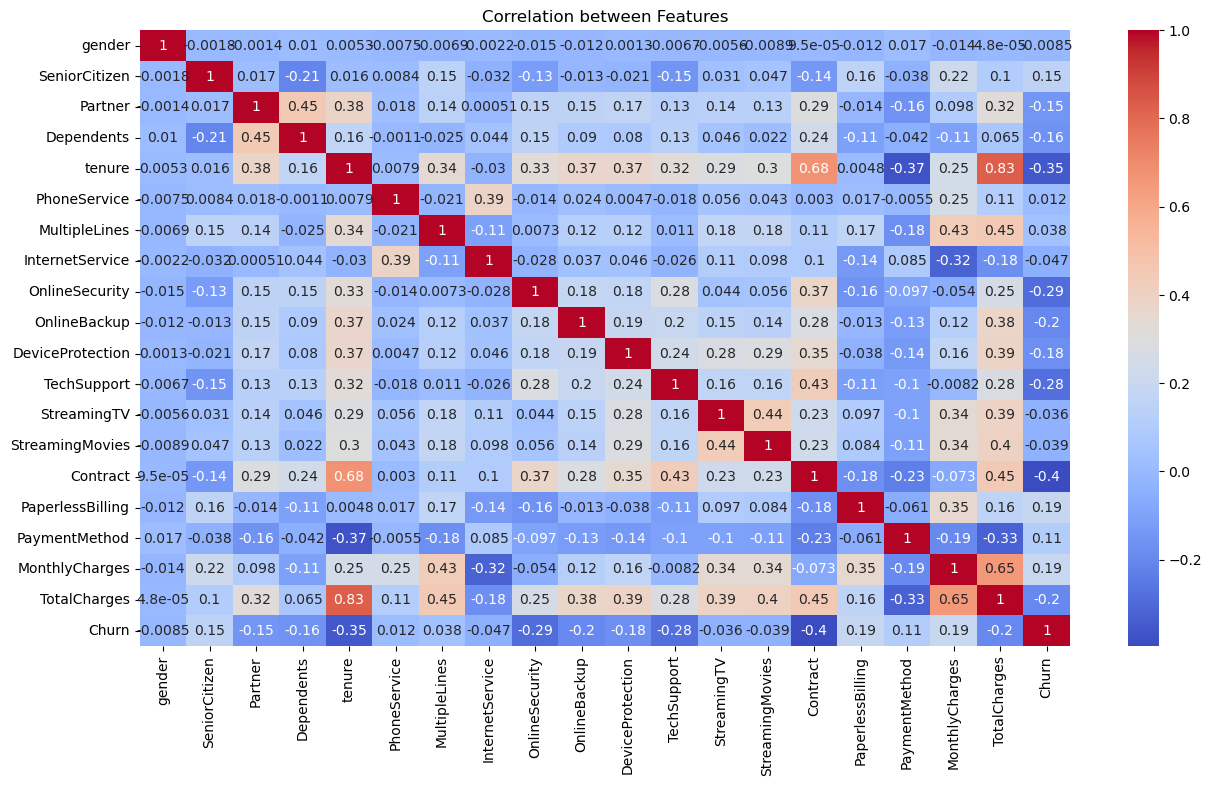

In [50]:
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Features")
plt.show()


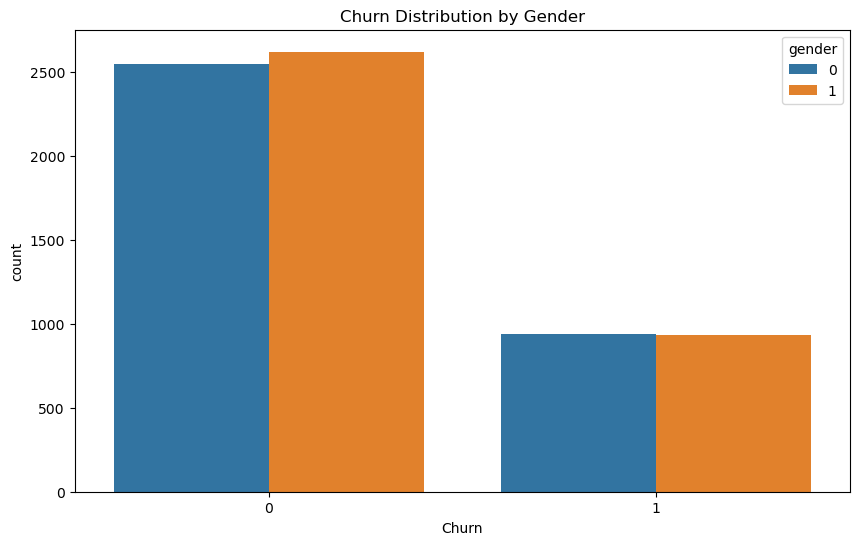

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Churn', hue='gender')
plt.title("Churn Distribution by Gender")
plt.show()

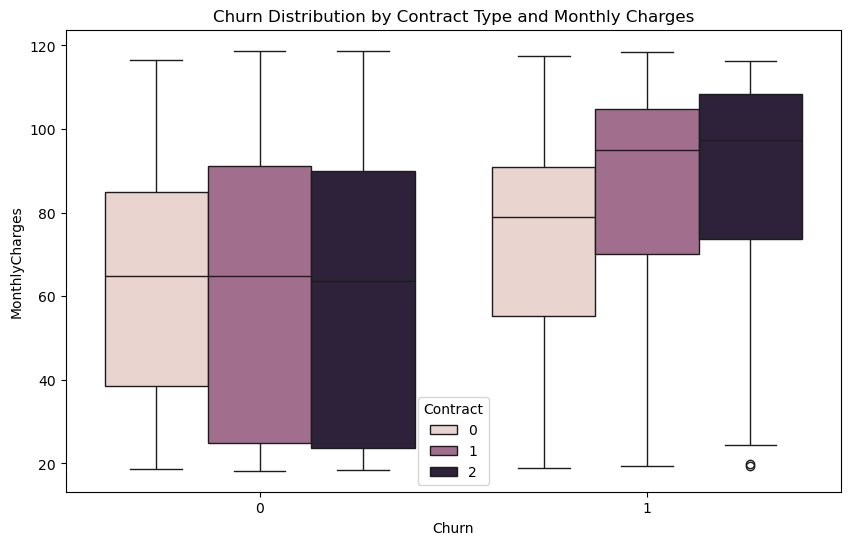

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='Churn', y='MonthlyCharges', hue='Contract')
plt.title("Churn Distribution by Contract Type and Monthly Charges")
plt.show()

<h1 style='text-align: center;'>Feature Engineering</h1>

In [60]:
X_train['contract_length'] = X_train['tenure'] * X_train['MonthlyCharges']
X_train['monthly_fee_ratio'] = X_train['MonthlyCharges'] / (X_train['TotalCharges'] + 1)

In [62]:
X_test['contract_length'] = X_test['tenure'] * X_test['MonthlyCharges']
X_test['monthly_fee_ratio'] = X_test['MonthlyCharges'] / (X_test['TotalCharges'] + 1)

<h1 style='text-align: center;'>Modeling</h1>

In [67]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [69]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [71]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier()

<h1 style='text-align: center;'>Model Evaluation</h1>

In [74]:
models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'Gradient Boosting': gb}
results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    results[model_name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
print("Model Performance:")
print(pd.DataFrame(results))

Model Performance:
           Logistic Regression  Random Forest  Gradient Boosting
Accuracy              0.791756       0.788202           0.793177
Precision             0.637288       0.641791           0.649819
Recall                0.502674       0.459893           0.481283
AUC                   0.833189       0.816488           0.831918


<h2 style='text-align: center;'>Detailed Model Comparison and Insights</h2>

In [79]:
best_model = rf

<h2 style='text-align: center;'>Confusion Matrix</h2>

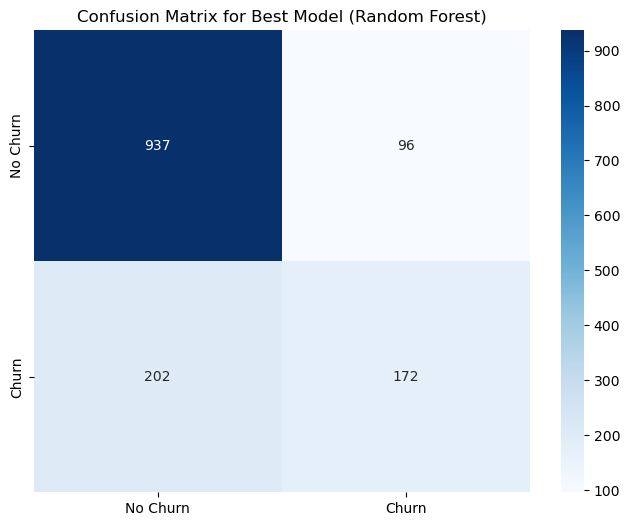

In [81]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix for Best Model (Random Forest)")
plt.show()

<h2 style='text-align: center;'>Classification Report</h2>

In [89]:
print("Classification Report:")
print(classification_report(y_test, best_model.predict(X_test)))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407



<h2 style='text-align: center;'>ROC Curve</h2>

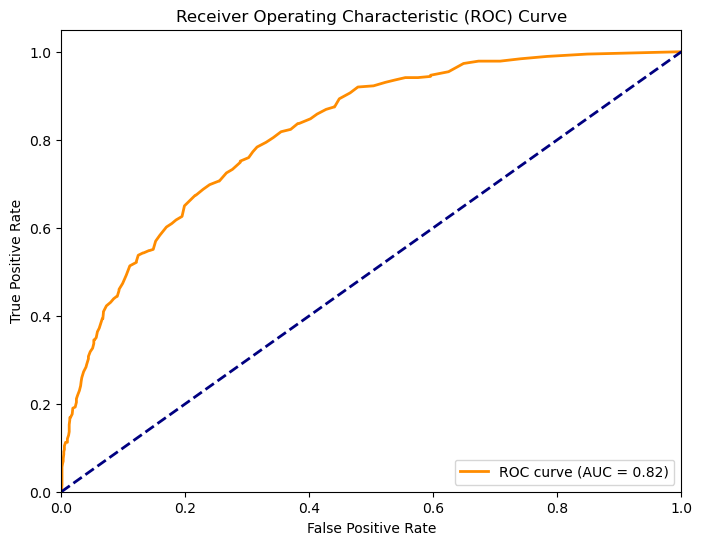

In [94]:
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


<h2 style='text-align: center;'>Actual vs Predicted Comparison</h2>

In [97]:
predicted_churn = pd.DataFrame({'Actual': y_test, 'Predicted': best_model.predict(X_test)})
predicted_churn = predicted_churn.reset_index(drop=True)

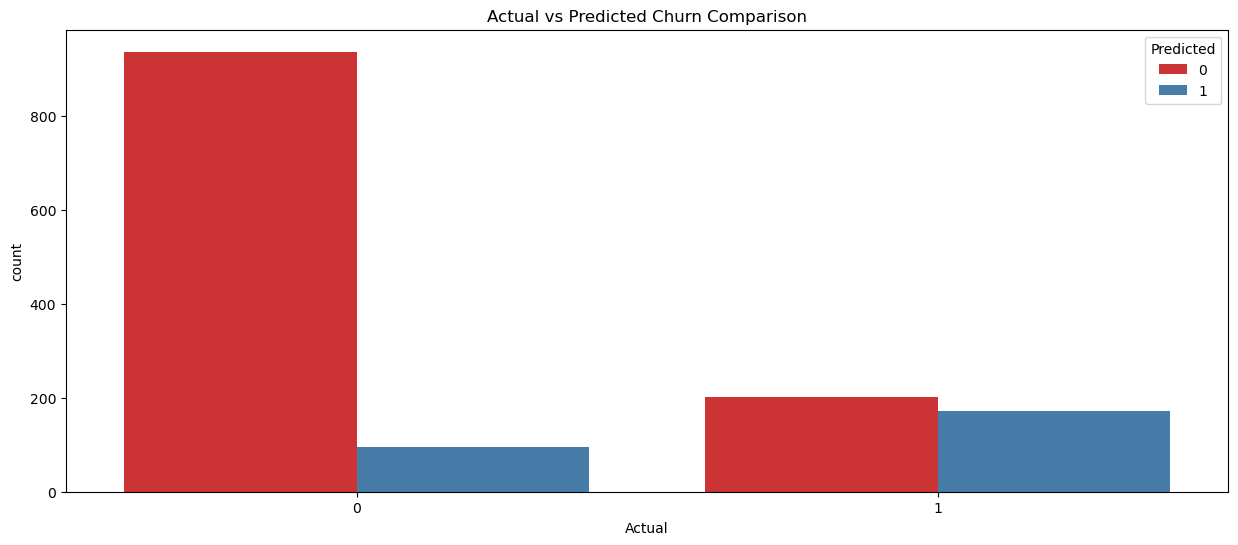

In [99]:
plt.figure(figsize=(15, 6))
sns.countplot(data=predicted_churn, x='Actual', hue='Predicted', palette="Set1")
plt.title("Actual vs Predicted Churn Comparison")
plt.show()

<h2 style='text-align: center;'>Interpretation</h2>

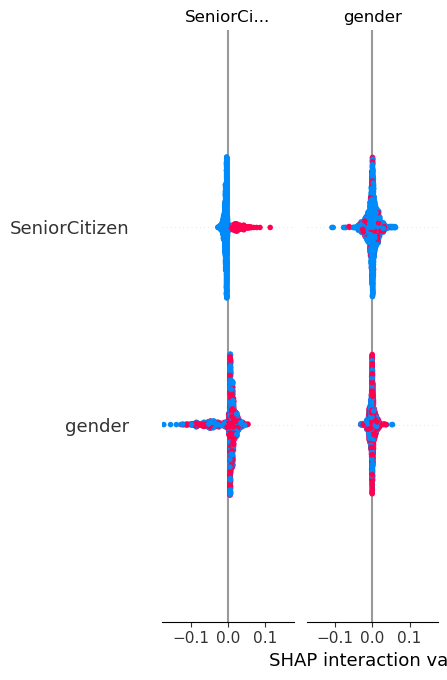

In [104]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

<h1 style='text-align: center;'>Prediction Function</h1>

In [107]:
def predict_churn(input_data):
    input_df = pd.DataFrame([input_data])
    for col in data.select_dtypes(include=['object']).columns:
        if col in input_df.columns:
            input_df[col] = LabelEncoder().fit_transform(input_df[col])
    input_df['contract_length'] = input_df['tenure'] * input_df['MonthlyCharges']
    input_df['monthly_fee_ratio'] = input_df['MonthlyCharges'] / (input_df['TotalCharges'] + 1)
    prediction = best_model.predict(input_df)
    probability = best_model.predict_proba(input_df)[:, 1]
    return {'Churn Prediction': prediction[0], 'Churn Probability': probability[0]}


<h2 style='text-align: center;'>Example Prediction</h2>

In [110]:
sample_input = X_test.iloc[0].to_dict()
print("Prediction for Sample Input:", predict_churn(sample_input))

Prediction for Sample Input: {'Churn Prediction': 0, 'Churn Probability': 0.0}


In [112]:
import pickle
model = models['Random Forest']  
with open("trained_model.pkl", "wb") as file:
    pickle.dump(model, file)
